# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, Imputer
from sklearn.decomposition import PCA

%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

#### Azdias

In [3]:
# Check the structure of the data
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


Will definitely need the feature summaries to understand all of this!

In [4]:
# Check shape, missing data and datatype
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

The data has 891,220 rows and 85 columns. There is definitely missing data in the set.

In [5]:
# Get null counts
original_missing = azdias.isnull().sum()
original_missing.sum()

4896838

There were originally 4,896,838 values that were missing.

In [6]:
# Get counts of unique values
azdias.nunique()

AGER_TYP                    5
ALTERSKATEGORIE_GROB        5
ANREDE_KZ                   2
CJT_GESAMTTYP               6
FINANZ_MINIMALIST           5
FINANZ_SPARER               5
FINANZ_VORSORGER            5
FINANZ_ANLEGER              5
FINANZ_UNAUFFAELLIGER       5
FINANZ_HAUSBAUER            5
FINANZTYP                   6
GEBURTSJAHR               117
GFK_URLAUBERTYP            12
GREEN_AVANTGARDE            2
HEALTH_TYP                  4
LP_LEBENSPHASE_FEIN        41
LP_LEBENSPHASE_GROB        13
LP_FAMILIE_FEIN            12
LP_FAMILIE_GROB             6
LP_STATUS_FEIN             10
LP_STATUS_GROB              5
NATIONALITAET_KZ            4
PRAEGENDE_JUGENDJAHRE      16
RETOURTYP_BK_S              5
SEMIO_SOZ                   7
SEMIO_FAM                   7
SEMIO_REL                   7
SEMIO_MAT                   7
SEMIO_VERT                  7
SEMIO_LUST                  7
                         ... 
OST_WEST_KZ                 2
WOHNLAGE                    8
CAMEO_DEUG

#### Feature Info

In [7]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
## Identify missing or unknown data values and convert them to NaNs.
# Strip [] from feat_info.missing_or_unknown
feat_info_clean = feat_info.copy()
feat_info_clean.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[').str.strip(']')

In [10]:
feat_info_clean.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"-1,0"
1,ALTERSKATEGORIE_GROB,person,ordinal,"-1,0,9"
2,ANREDE_KZ,person,categorical,"-1,0"
3,CJT_GESAMTTYP,person,categorical,0
4,FINANZ_MINIMALIST,person,ordinal,-1


In [11]:
# Extract values
feat_info_clean[['first_null', 'second_null', 'third_null']] = feat_info_clean.missing_or_unknown.str.split(',', expand=True)
feat_info_clean.head()

,attribute,information_level,type,missing_or_unknown,first_null,second_null,third_null
0,AGER_TYP,person,categorical,"-1,0",-1,0,None
1,ALTERSKATEGORIE_GROB,person,ordinal,"-1,0,9",-1,0,9
2,ANREDE_KZ,person,categorical,"-1,0",-1,0,None
3,CJT_GESAMTTYP,person,categorical,0,0,None,None
4,FINANZ_MINIMALIST,person,ordinal,-1,-1,None,None


In [12]:
## Create dataframe to assist with replacing 
replace_df = feat_info_clean[['attribute', 'first_null', 'second_null', 'third_null']]
# Transpose for easier comparisons
replace_df = replace_df.set_index('attribute').transpose()
replace_df.head()

attribute,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
first_null,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
second_null,0,0,0,None,None,None,None,None,None,None,...,None,None,None,None,0,None,None,9,0,9
third_null,None,9,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


All of the values were strings. I wanted to convert as many to floats as possible to ensure that numerical data was being captured. I'll do the same for the main dataset.

In [13]:
# Convert as many columns to float as possible
for col in replace_df.columns:
    try:
        replace_df[col] = replace_df[col].astype(float)
    except:
        continue

In [14]:
(replace_df.dtypes == 'float64').sum()

72

In [15]:
(azdias.dtypes == 'float64').sum()

49

71 columns were converted to float. Which columns weren't converted?

In [16]:
replace_df.transpose()[replace_df.dtypes != float]

,first_null,second_null,third_null
attribute,,,
GFK_URLAUBERTYP,,None,None
GREEN_AVANTGARDE,,None,None
ANZ_PERSONEN,,None,None
ANZ_TITEL,,None,None
ANZ_HH_TITEL,,None,None
KONSUMNAEHE,,None,None
CAMEO_DEUG_2015,-1,X,None
CAMEO_DEU_2015,XX,None,None
CAMEO_INTL_2015,-1,XX,None


There are the four that are clearly not numerical (and are consistent with the main set), but then there are the 10 other ones. An inspection of the data dictionary indicates that there is nothing listed here. (This makes sense since there were empty lists in the original verion). 

This is ok because there won't be any values in the corresponding columns that match this and so replace will still work. I can create a dictionary from here.

In [17]:
replace_dict = replace_df.to_dict(orient='list')

Now that the dictionary is created, now is the time to convert the main dictionary to floats (makes sense since we'll have nan's) and then replace.

In [18]:
# Create copy to retain original data
azdias_clean = azdias.copy()

In [19]:
# Convert to float wherever possible
for col in azdias_clean.columns:
    try:
        azdias_clean[col] = azdias_clean[col].astype(float)
    except:
        continue

In [20]:
azdias_clean.replace(replace_dict, np.nan, inplace=True)

In [21]:
replaced = azdias_clean.isnull().sum()
replaced.sum()

8373929

There are now 8,373,929 values that are missing. That's a LOT of missing values! However, the main dataset has over 75M different data points across the rows, so it's still only a bit over 10%, so not that unexpected.

In [22]:
(replaced - original_missing).sum()

3477091

Conducting this replacement found an additional 3,477,091 missing values.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [23]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
replaced

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

There is certainly a range of missing data in the columns - some columns have no missing data while others have over 100k. Let's look at the full distribution.

In [24]:
# Investigate patterns in the amount of missing data in each column.
replaced.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

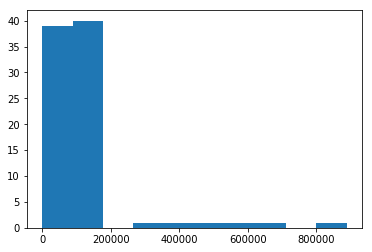

In [25]:
replaced.hist(grid=False);

The maximum number of values missing from a column is 889,061. Given that are 891,221 rows of data, this is over 90% missing data. The majority of columns have less than 120k pieces of missing data, but there are approximately five that are higher.

In [26]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
high_missing = replaced[replaced > 200000].index
azdias_clean.drop(high_missing, axis=1, inplace=True)
azdias_clean.shape

(891221, 79)

In [27]:
high_missing

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

The six columns that were dropped were `AGER_TYP`, `GEBURTSJAHR`, `TITEL_KZ`, `ALTER_HH`, `KK_KUNDENTYP`, and       `KBA05_BAUMAX`.

Let's see if there are any patterns in missing data across the columns.

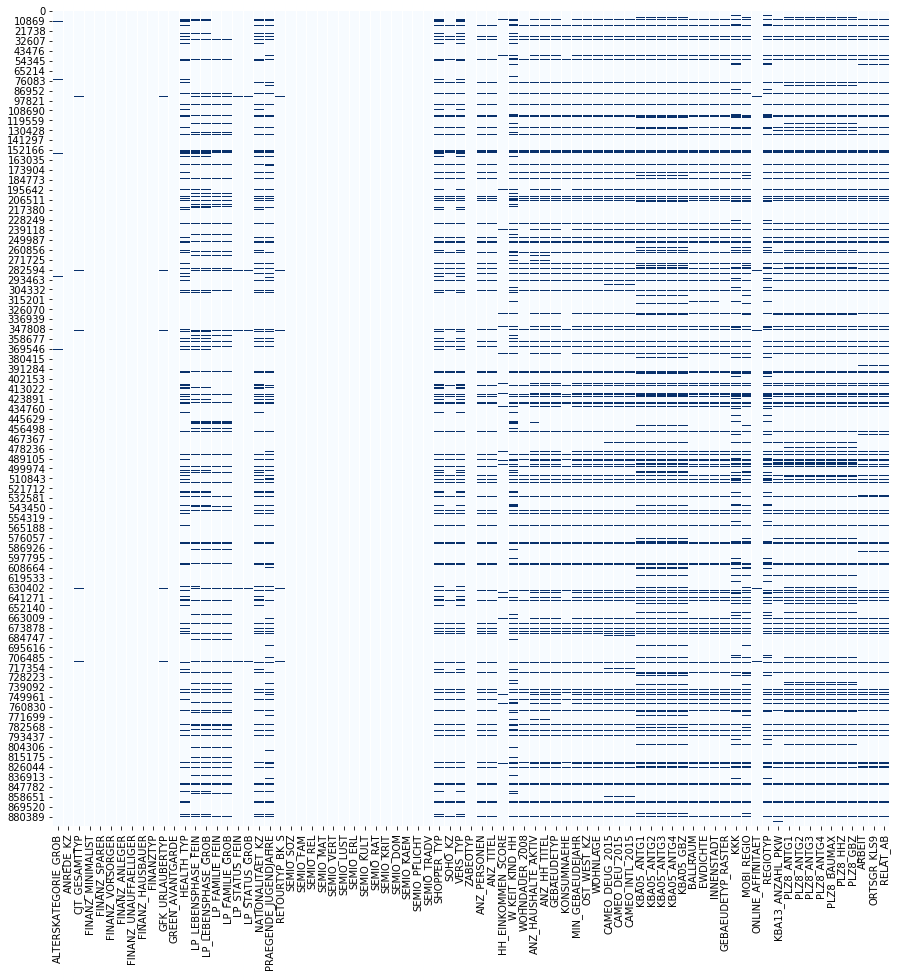

In [28]:
plt.figure(figsize=(15,15))
sns.heatmap(azdias_clean.isnull(), cmap='Blues', cbar=False); # Missing values are dark blue

Let's inspect the first set columns that are likely to have missing data - from `HEALTH_TYP` to `PRAEGENDE_JUGENDJAHRE`.

In [29]:
feat_info_clean.iloc[14:23]

,attribute,information_level,type,missing_or_unknown,first_null,second_null,third_null
14,HEALTH_TYP,person,ordinal,"-1,0",-1,0,None
15,LP_LEBENSPHASE_FEIN,person,mixed,0,0,None,None
16,LP_LEBENSPHASE_GROB,person,mixed,0,0,None,None
17,LP_FAMILIE_FEIN,person,categorical,0,0,None,None
18,LP_FAMILIE_GROB,person,categorical,0,0,None,None
19,LP_STATUS_FEIN,person,categorical,0,0,None,None
20,LP_STATUS_GROB,person,categorical,0,0,None,None
21,NATIONALITAET_KZ,person,categorical,"-1,0",-1,0,None
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"-1,0",-1,0,None


The information appears to be related to personal, health, and family matters.

In [30]:
# Determine the index of the first column in the second half that has regular missing data
feat_info_clean.query('attribute == "SHOPPER_TYP"')

,attribute,information_level,type,missing_or_unknown,first_null,second_null,third_null
38,SHOPPER_TYP,person,categorical,-1,-1,None,None


In [31]:
feat_info_clean.iloc[38:]

,attribute,information_level,type,missing_or_unknown,first_null,second_null,third_null
38,SHOPPER_TYP,person,categorical,-1,-1,None,None
39,SOHO_KZ,person,categorical,-1,-1,None,None
40,TITEL_KZ,person,categorical,"-1,0",-1,0,None
41,VERS_TYP,person,categorical,-1,-1,None,None
42,ZABEOTYP,person,categorical,"-1,9",-1,9,None
43,ALTER_HH,household,interval,0,0,None,None
44,ANZ_PERSONEN,household,numeric,,,None,None
45,ANZ_TITEL,household,numeric,,,None,None
46,HH_EINKOMMEN_SCORE,household,ordinal,"-1,0",-1,0,None
47,KK_KUNDENTYP,household,categorical,-1,-1,None,None


There does seem to be some patterns in the missing data. When data is missing from `HEALTH_TYP` it is commonly missing from the majority of the columns in the dataset. Based on a quick scan of the columns, it appears that these may be more sensitive personal/household demographic questions, building type information, and location/geographic information. Some of this may be preferred not to be shared or more likely to be unknown and therefore not recorded.

#### Discussion 1.1.2: Assess Missing Data in Each Column

The average count for missing values for each column is 76,812, which is less than 10% of the data. However, the maximum number of missing values for a single column ranged all the way up to 685,843, which is more than 75% of the entire dataset. 

A plot of the distribution of missing data indicated that there were a few columns that had much higher numbers of missing values. These were `AGER_TYP`, `GEBURTSJAHR`, and `KK_KUNDENTYP`. These values were dropped from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [32]:
# How much data is missing in each row of the dataset?
missing_rows = azdias_clean.isnull()
missing_rows.sum(axis=1)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [33]:
missing_row_totals = missing_rows.sum(axis=1)
missing_row_totals.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

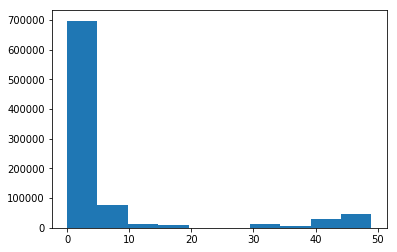

In [34]:
missing_row_totals.hist(grid=False);

The data here is highly right-skewed, with a small increase towards the end of the tail. What's good for us is that more than 50% of the data has no missing values, and 75% has 3 or fewer missing values. It appears that some columns never have missing values, as the highest number of missing data per row is 49.

I decided to create a column that clearly distinguished which rows had no missing data.

In [35]:
azdias_clean['complete'] = azdias_clean.isnull().sum(axis=1) == 0
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,complete
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,True
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,True
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,False
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,True


In [36]:
# Count of rows with no missing data
azdias_clean.complete.sum()

623209

In [37]:
# % of rows with no missing data
azdias_clean.complete.sum()/azdias_clean.shape[0]

0.6992754883468859

If we drop all rows with missing data we will still retain almost 70% of the dataset. However, before we do, it's a good idea to check if there are differences between the data we plan to retain and the data we plan to drop.

Let's compare the distribution of values for some of the columns where there is limited missing data between the datasets with missing and no missing values.

In [38]:
# Collect columns with limited missing values
low_missing_columns = replaced[replaced < 5].index # replaced previous collected missing counts per column
print('# Columns with low missing values:', len(low_missing_columns))

# Columns with low missing values: 24


There are columns that have low missing values. Let's pick 5 of them at random to compare between the two datasets with zero or missing row values.

In [39]:
sample_columns = np.random.choice(low_missing_columns, 5)
sample_columns

array(['FINANZ_MINIMALIST', 'SEMIO_ERL', 'GREEN_AVANTGARDE', 'SEMIO_FAM',
       'SEMIO_LUST'], dtype=object)

In [40]:
# Add 'complete' to column list
sample_columns_list = list(sample_columns)
sample_columns_list.append('complete')
azdias_clean[sample_columns_list].head()

,FINANZ_MINIMALIST,SEMIO_ERL,GREEN_AVANTGARDE,SEMIO_FAM,SEMIO_LUST,complete
0,3.0,3.0,0.0,6.0,5.0,False
1,1.0,2.0,0.0,4.0,2.0,True
2,1.0,6.0,1.0,1.0,4.0,True
3,4.0,7.0,0.0,1.0,4.0,False
4,4.0,4.0,0.0,4.0,4.0,True


In [41]:
def facet_count(data, selected_col):
    complete = azdias_clean[azdias_clean['complete']]
    incomplete = azdias_clean[~azdias_clean['complete']]
    selected_color = sns.color_palette()[0]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(x=selected_col, data=complete, color=selected_color)
    plt.title('Complete')
    plt.xlabel('')
    plt.ylabel('')
    plt.subplot(1, 2, 2)
    sns.countplot(x=selected_col, data=incomplete, color=selected_color)
    plt.title('Incomplete')
    plt.xlabel('')
    plt.ylabel('')
    plt.suptitle(selected_col, y=1.07)
    plt.show();

**Count Plots for Random Columns**

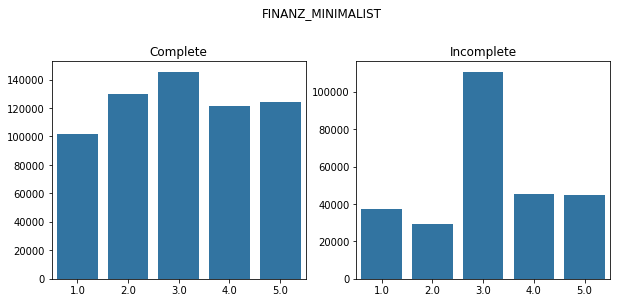

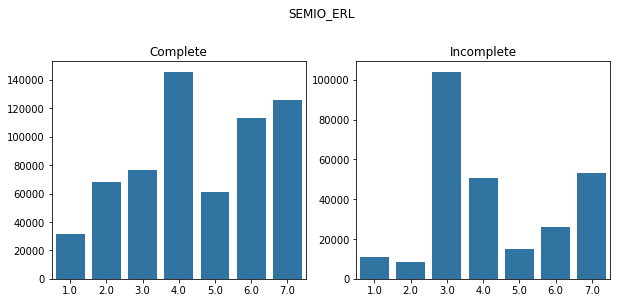

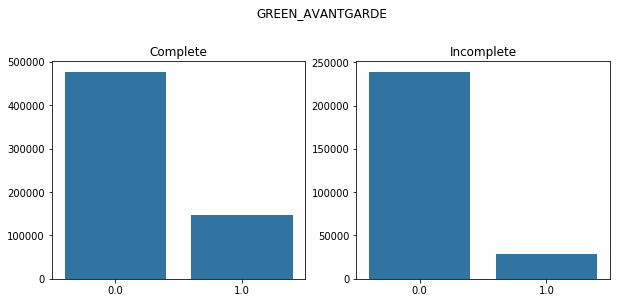

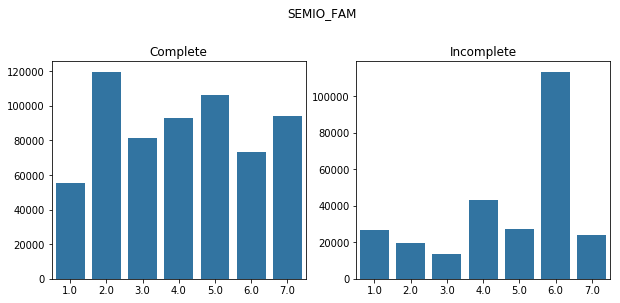

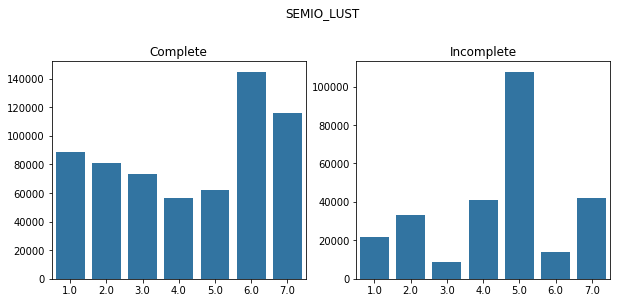

In [42]:
for col in sample_columns:
    facet_count(azdias_clean, col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

There does seem to be a qualitative difference in these demographics when comparing those with large amounts of missing data in other columns and those that do not. This suggests that if we simply drop this missing data we will be removing substantial proportions of data that do represent different segments of the population. It would be good to find a way to keep it if at all possible.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [43]:
# How many features are there of each data type?
feat_info_clean.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

The majority of the data is ordinal, categorical or mixed. There are only 8 columns that are numeric or interval.

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

**Binary features**

In [44]:
# Drop previously dropped columns from feat_info_clean
feat_info_clean = feat_info_clean[~feat_info_clean.attribute.isin(high_missing)]

In [45]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Collect categorical columns
categorical_columns = feat_info_clean.query('type == "categorical"').attribute
print('# Categorical features:', len(categorical_columns))

# Find binary columns
binary_columns = []
for col in categorical_columns:
    value_count = azdias_clean[col].value_counts()
    if len(value_count) ==2:
        binary_columns.append(col)
print('# Binary features:', len(binary_columns))

# Categorical features: 18
# Binary features: 5


In [46]:
binary_columns

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Of the remaining columns, there are 18 categorical columns, five of which are binary. Which one is the one that needs to be recoded?

In [47]:
for col in binary_columns:
    if azdias_clean[col].dtypes == object:
        print(azdias_clean[col].value_counts())

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


`OST_WEST_KZ` is binary but encoded using `W` and `O`, therefore it needs to be recoded.

In [48]:
recode = {'O': 0, 'W': 1}
azdias_clean.replace({'OST_WEST_KZ': recode}, inplace=True)

In [50]:
# Test
assert(azdias_clean.OST_WEST_KZ.unique().all() in [0, 1])

**Multi-level Features**

In [52]:
# Investigate multi-level features
multi_columns = categorical_columns[~categorical_columns.isin(binary_columns)]
multi_columns

3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
42            ZABEOTYP
52         GEBAEUDETYP
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [53]:
for col in multi_columns:
    value_counts = azdias_clean[col].value_counts()
    print('\n')
    print(value_counts)
    print('Total:', value_counts.sum())



4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64
Total: 886367


6.0    290367
1.0    199572
4.0    130625
2.0    110867
5.0    106436
3.0     53354
Name: FINANZTYP, dtype: int64
Total: 891221


12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64
Total: 886367


1.0     426379
10.0    137913
2.0     104305
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64
Total: 813429


1.0    426379
5.0    200780
2.0    104305
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64
Total: 813429


1.0     219275
9.0     143238
2.0     118236
10.0    118022
4.0      78317
5.0      74493
3.0      74105
6.0      30914
8.0      19708
7.0      10059
Name: LP_STAT

In a perfect analysis, when deciding to drop these variables I would confirm my assumptions about the relationships between these variables. However, given that we were told it was fine to drop all of them, I am going to make some general assumptions and just keep variables that seem to preserve unique information.

These are the definitions of each of the multi-level categorical variables: 
- `CJT_GESAMTTYP`: preferred information and buying channels for consumer (includes details of consumption minimalist and traditionalist, store and online shoppers, and cross-channel types)
- `FINANZTYP`: Most descriptive financial type for individual (includes: low financial interest, money-saver, home ownership, be prepared, investor, inconspicuous)
    - Investigation of the data dictionary indicates that the variables contained in this feature are actually found their own variables with scales.
    
- `GFK_URLAUBERTYP`: Vacation habits (includes various types of vacation)
- `LP_FAMILIE_FEIN`: Family type using a fine scale (distinguishes in age, whether partnered, and children age, and generational families)
- `LP_FAMILIE_GROB`: Family type using a broader scale (captures the above categories in broader definitions)
- `LP_STATUS_FEIN`: Social status using a fine scale (distinguishes between low and high income earners as well as some elements of living/work style)
- `LP_STATUS_GROB`: Socail status using a rough scale (captures the above categories in broader definitions)
- `NATIONALITAET_KZ`: Nationality based on given name analysis (includes categories of German-sounding, foreign-sounding, assimilated names)
- `SHOPPER_TYP`: Shopper typology (includes different kinds of shopper habits)
- `ZABEOTYP`: Energy consumption typology (includes categories of consumer decision making approach in considering 'green' alternatives)
- `GEBAEUDETYP`: Type of building - uncertain if this means lived in? (includes different building types)
    - Investigation of the data dictionary indicates that there is a binary variable that indicates youth participation in an environmental sustainability group. 
    
- `CAMEO_DEU_2015`: Wealth / Life Stage Typology using a fine scale (includes different descriptions of class)
- `CAMEO_DEUG_2015`: Wealth / Life Stage Typology using a broader scale (captures the above categories in broader definitions)

In considering which variables to keep, I decided to keep broader scales over finer scales (as we are trying to reduce dimensionality in pca). I also looked to identify variables that seemed likely to capture the same type of data and only keep one of these. 

##### Financial Status
The variables that appeared to best fall into this category include:
- `LP_STATUS_FEIN`
- `LP_STATUS_GROB`
- `CAMEO_DEU_2015`
- `CAMEO_DEUG_2015`
- `FINANZTYP`

Because financial information is already captured in other variables, these can all be dropped.

##### Shopper/Consumer Type
The variables that appeared to best fall into this category include:
- `CJT_GESAMTTYP`
- `SHOPPER_TYP`
- `ZABEOTYP`

`ZABEOTYP`(green consumer type) can be dropped because it has a similar enough capturing in another binary variable. I decided to include `CJT_GESAMTTYP` (for marketing/shopping behaviour) and  for different types of clustering. I decided not to include `SHOPPER_TYP` because it seemed too similar to `CJT_GESAMTTYP`.

##### Family Status
In line with my above reasoning, I decided to keep `LP_FAMILIE_GROB` over `LP_FAMILIE_FEIN`

##### Other Clusters
I also decided to keep `GFK_URLAUBERTYP`, and `NATIONALITAET_KZ`, as other potential 'type' clustering mechanisms. I decided to exclude `GEBAEUDETYP` because I didn't really understand how to interpret/apply it.

As a result the columns to keep are: 
- `CJT_GESAMTTYP`
- `LP_FAMILIE_GROB`
- `GFK_URLAUBERTYP`
- `NATIONALITAET_KZ`

In [54]:
# Drop excluded columns
drop_columns = ['LP_STATUS_FEIN', 'LP_STATUS_GROB', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'FINANZTYP',  
                'SHOPPER_TYP', 'ZABEOTYP', 'LP_FAMILIE_FEIN', 'GEBAEUDETYP']
azdias_clean.drop(drop_columns, axis=1, inplace=True)

In [56]:
## Re-encode categorical variable(s) to be kept in the analysis.
# Define categorical columns
cat_keep_columns = ['CJT_GESAMTTYP', 'LP_FAMILIE_GROB', 
                    'GFK_URLAUBERTYP', 'NATIONALITAET_KZ']

# Create df for cat and non-cat columns
azdias_cat = azdias_clean[cat_keep_columns]
azdias_non_cat = azdias_clean.drop(cat_keep_columns, axis=1)

# Implement one-hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
azdias_encode_cat = enc.fit_transform(azdias_cat.fillna(0)).toarray() # Use fillna to create column for missing values

In [57]:
# Create column list for categories 
cat_cols = ['CJT_GESAMTTYP_0', 'CJT_GESAMTTYP_1', 'CJT_GESAMTTYP_2', 'CJT_GESAMTTYP_3', 
            'CJT_GESAMTTYP_4', 'CJT_GESAMTTYP_5', 'CJT_GESAMTTYP_6', 'LP_FAMILIE_GROB_0',
            'LP_FAMILIE_GROB_1', 'LP_FAMILIE_GROB_2', 'LP_FAMILIE_GROB_3', 
            'LP_FAMILIE_GROB_4', 'LP_FAMILIE_GROB_5', 'GFK_URLAUBERTYP_0', 'GFK_URLAUBERTYP_1', 
            'GFK_URLAUBERTYP_2', 'GFK_URLAUBERTYP_3', 'GFK_URLAUBERTYP_4', 
            'GFK_URLAUBERTYP_5', 'GFK_URLAUBERTYP_6', 'GFK_URLAUBERTYP_7', 
            'GFK_URLAUBERTYP_8', 'GFK_URLAUBERTYP_9', 'GFK_URLAUBERTYP_10', 
            'GFK_URLAUBERTYP_11', 'GFK_URLAUBERTYP_12', 'NATIONALITAET_KZ_0', 'NATIONALITAET_KZ_1', 
            'NATIONALITAET_KZ_2', 'NATIONALITAET_KZ_3']

In [58]:
# Join cat back on to df
# https://stackoverflow.com/questions/50414823/how-to-keep-columns-names-after-one-hot-encoding-sklearn
azdias_dummies = azdias_non_cat.join(
    pd.DataFrame(azdias_encode_cat, azdias_non_cat.index, columns=cat_cols)
)
azdias_dummies.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_8,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_12,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [59]:
azdias_dummies.shape

(891221, 97)

#### Discussion 1.2.1: Re-Encode Categorical Features

All categorical variables were identified (after previously dropping some columsn due to high levels of missing values). There were 18 with five that were binary. 

`OST_WEST_KZ` was identified as a binary variable that was encoded with strings and so this was converted to a binary variable with [0, 1] as it's classes. 

The remaining categorical variables were inspected for their ability to contribute to determining latent features. Features were dropped if they contained information mostly captured in other variables or if they were encoding data with fine detail when a rough detail alternative was available. 

As a result, the following categorical variables were retained:
- `CJT_GESAMTTYP`
- `LP_FAMILIE_GROB`
- `GFK_URLAUBERTYP`
- `NATIONALITAET_KZ`

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

##### PRAEGENDE_JUGENDJAHRE
The levels for this feature are as follows:
1. 40s - war years (Mainstream, E+W)
2. 40s - reconstruction years (Avantgarde, E+W)
3. 50s - economic miracle (Mainstream, E+W)
4. 50s - milk bar / Individualisation (Avantgarde, E+W)
5. 60s - economic miracle (Mainstream, E+W)
6. 60s - generation 68 / student protestors (Avantgarde, W)
7. 60s - opponents to the building of the Wall (Avantgarde, E)
8. 70s - family orientation (Mainstream, E+W)
9. 70s - peace movement (Avantgarde, E+W)
10. 80s - Generation Golf (Mainstream, W)
11. 80s - ecological awareness (Avantgarde, W)
12. 80s - FDJ / communist party youth organisation (Mainstream, E)
13. 80s - Swords into ploughshares (Avantgarde, E)
14. 90s - digital media kids (Mainstream, E+W)
15. 90s - ecological awareness (Avantgarde, E+W)

It would be convenient if all odd or even numbers were associated with mainstream or avantgarde, but this is not the case. The values for the decades are also strange in their groupings - most have two values but the 60s and 80s have more.

Mainstream and avantgarde will be encoded as binary [0, 1]. The generations will be encoded as full years to better capture the differences between the numbers.

In [60]:
## "PRAEGENDE_JUGENDJAHRE": engineer two new variables.
# https://chrisalbon.com/python/data_wrangling/pandas_create_column_using_conditional/
# Code MAINSTREAM_AVANTGARDE
mainstream_values = [1, 3, 5, 8, 10, 12, 14]
azdias_dummies['MAINSTREAM_AVANTGARDE'] = np.where(
    azdias_dummies.PRAEGENDE_JUGENDJAHRE.isin(mainstream_values), 0, 1)

# Code DECADE
decade_replace = {'1.0': 1940, '2.0': 1940, '3.0': 1950, '4.0': 1950, '5.0': 1960, 
                  '6.0': 1960, '7.0': 1960, '8.0': 1970, '9.0': 1970, '10.0': 1980, 
                  '11.0': 1980, '12.0': 1980, '13.0': 1980, '14.0': 1990, '15.0': 1990}

azdias_dummies.PRAEGENDE_JUGENDJAHRE = azdias_dummies.PRAEGENDE_JUGENDJAHRE.astype(str)
azdias_dummies.replace({'PRAEGENDE_JUGENDJAHRE': decade_replace}, inplace=True)
azdias_dummies.rename(columns={'PRAEGENDE_JUGENDJAHRE': 'DECADE'}, inplace=True)

In [61]:
# Test
assert('DECADE' in azdias_dummies.columns)
assert('MAINSTREAM_AVANTGARDE' in azdias_dummies.columns)
print(azdias_dummies.DECADE.value_counts())
print(azdias_dummies.MAINSTREAM_AVANTGARDE.value_counts())

1990    231244
1970    179558
1980    151770
1960    116078
nan     108164
1950     75646
1940     28761
Name: DECADE, dtype: int64
0    607832
1    283389
Name: MAINSTREAM_AVANTGARDE, dtype: int64


##### CAMEO_INTL_2015
The levels for this feature are as follows:
11. Wealthy Households - Pre-Family Couples & Singles
12. Wealthy Households - Young Couples With Children
13. Wealthy Households - Families With School Age Children
14. Wealthy Households - Older Families &  Mature Couples
15. Wealthy Households - Elders In Retirement


21. Prosperous Households - Pre-Family Couples & Singles
22. Prosperous Households - Young Couples With Children
23. Prosperous Households - Families With School Age Children
24. Prosperous Households - Older Families & Mature Couples
25. Prosperous Households - Elders In Retirement


31. Comfortable Households - Pre-Family Couples & Singles
32. Comfortable Households - Young Couples With Children
33. Comfortable Households - Families With School Age Children
34. Comfortable Households - Older Families & Mature Couples
35. Comfortable Households - Elders In Retirement


41. Less Affluent Households - Pre-Family Couples & Singles
42. Less Affluent Households - Young Couples With Children
43. Less Affluent Households - Families With School Age Children
44. Less Affluent Households - Older Families & Mature Couples
45. Less Affluent Households - Elders In Retirement


51. Poorer Households - Pre-Family Couples & Singles
52. Poorer Households - Young Couples With Children
53. Poorer Households - Families With School Age Children
54. Poorer Households - Older Families & Mature Couples
55. Poorer Households - Elders In Retirement

This means that data can be considered interval and split between the first and second value. I can convert these to `str`, take the first and second string for new columns, convert to `int` and drop the original column.

In [65]:
## "CAMEO_INTL_2015": engineer two new variables.
# Create WEALTH (Using dropna to managed nan's)
azdias_dummies['WEALTH'] = azdias_dummies.CAMEO_INTL_2015.dropna().astype(str).str[0].astype(int)
# Convert WEALTH so that low value corresponds to low wealth 
azdias_dummies['WEALTH'] = azdias_dummies['WEALTH'] - 5
azdias_dummies['WEALTH'] = azdias_dummies['WEALTH'].abs()
# Create FAMILY_TYP (Using dropna to managed nan's)
azdias_dummies['FAMILY_TYP'] = azdias_dummies.CAMEO_INTL_2015.dropna().astype(str).str[1].astype(int)
# Drop CAMEO_INTL_2015
azdias_dummies.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [66]:
# Test
assert('WEALTH' in azdias_dummies.columns)
assert('FAMILY_TYP' in azdias_dummies.columns)
assert('CAMEO_INTL_2015' not in azdias_dummies.columns)
print(azdias_dummies.WEALTH.value_counts())
print(azdias_dummies.FAMILY_TYP.value_counts())

0.0    223582
3.0    190691
1.0    189960
4.0    119443
2.0     68193
Name: WEALTH, dtype: int64
1.0    245054
4.0    232777
3.0    119693
5.0    117045
2.0     77300
Name: FAMILY_TYP, dtype: int64


##### Check Other Mixed-Type

In [67]:
feat_info_clean.query('type == "mixed"')

,attribute,information_level,type,missing_or_unknown,first_null,second_null,third_null
15,LP_LEBENSPHASE_FEIN,person,mixed,0,0,None,None
16,LP_LEBENSPHASE_GROB,person,mixed,0,0,None,None
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"-1,0",-1,0,None
56,WOHNLAGE,building,mixed,-1,-1,None,None
59,CAMEO_INTL_2015,microcell_rr4,mixed,"-1,XX",-1,XX,None
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"-1,0",-1,0,None


We've already addressed `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015`. Let's have a look at the others.

`LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` provide additional age and income information in fine and rough scale, respectively. This information is already captured and so does not need to be included. 

`WOHNLAGE` provides information about the type of neighbourhood the individual lives in. I haven't encountered this information before so it could be helpful to retain. It is primarily interval information except for the last two that define rural neighbourhoods, the second in a new building. I'd like to see the value counts here.

In [68]:
azdias_dummies.WOHNLAGE.value_counts()

3.0    249719
7.0    169318
4.0    135973
2.0    100376
5.0     74346
1.0     43918
8.0     17473
0.0      6950
Name: WOHNLAGE, dtype: int64

The concept of being rural is captured in another variable `BALLRAUM` (distance to nearest urban center). So it could be reasonable to convert the values for 7 and 8 to nan's and retain the remainder of the neighborhood wealth details.

In [69]:
# Replace two rural indicators, and 'not calculated' as nan
azdias_dummies.WOHNLAGE.replace([7.0, 8.0, 0.0], np.nan, inplace=True)
#Test
assert(azdias_dummies.WOHNLAGE.isin([7.0, 8.0, 0.0]).sum() == 0)
# Convert WOHNLAGE so that low value corresponds to low wealth 
azdias_dummies['WOHNLAGE'] = azdias_dummies['WOHNLAGE'] - 5
azdias_dummies['WOHNLAGE'] = azdias_dummies['WOHNLAGE'].abs()

In [70]:
azdias_dummies.WOHNLAGE.value_counts()

2.0    249719
1.0    135973
3.0    100376
0.0     74346
4.0     43918
Name: WOHNLAGE, dtype: int64

`PLZ8_BAUMAX` provides information about the most common building type within the PLZ8 region. It appears that German postcode naming follows a consistent pattern across cities and I belive that this constitutes the major suburban area. ([Reference](http://www.ddsgeo.com/products/plz8.html)) As such, this provides a descriptor of the type of city in which an individual resides. However, there are a number of other variables that capture this type of information and so it does not need to be retained. 

In [74]:
# Drop PLZ8_BAUMAX, LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB 
azdias_dummies.drop(['PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Two of the mixed-type features could be easily engineered: `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015`. 

For `PRAEGENDE_JUGENDJAHRE` the data was separated into two features: `DECADE` and `MAINSTREAM_AVANTGARDE`. `DECADE` contains the decade of birth, ranging from 1940 to 1990. `MAINSTREAM_AVANTGARDE` describes the movement they are associated with, 0 for mainstream, and 1 for avantgarde. 

For `CAMEO_INTL_2015` the data was also separated into two features: `WEALTH` and `FAMILY_TYP`. `WEALTH` is an interval scale that ranges from Poorer (0) to Wealth (4). `FAMILY_TYP` is also an interval scale that ranges from Pre-Family Couples and Singles (1) to Elders in Retirement (5), capturing the 'life stage' of the individual.

The remaining mixed-type features were `LP_LEBENSPHASE_FEIN`, `LP_LEBENSPHASE_GROB`, `WOHNLAGE` and `PLZ8_BAUMAX`. 

`LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` both provide age financial information, but these have been captured elsewhere, so they were dropped. `PLZ8_BAUMAX` provides details of the type of city that an individual lives in by describing the types of buildings found in a key postal code. However, this information is captured in greater detail in a number of interval/ordinal features, so it's information is somewhat redundant and it was dropped. 

`WOHNLAGE` appeared to capture unique information about the wealth of the neighborhood an individual resided in. It was mixed because the final two levels captured residence in a rural area. Because living in a rural area is captured in `BALLRAUM` (distance to nearest urban centre), these levels were converted to nan's and the remaining levels were retained. This introduced 136,943 nan values into the column.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

##### Ordinal Features
I've looked at all of the features except for the ordinal and numeric features. I'd like to look at them just to be certain how they function - mostly I'm looking for ordinal features that are "reverse coded", that is, a low recorded value corresponds to a high actual value. I'd like to recode these just to make sure that I don't confuse any of the interepretations later down the line.

In [75]:
feat_info_clean.query('type == "ordinal"').shape[0]

49

Because there is such a large number of these features, rather than desribing each of them individually, I'll list them and then highlight if any are reverse scaled. 

In [76]:
feat_info_clean.query('type == "ordinal"').attribute

1      ALTERSKATEGORIE_GROB
4         FINANZ_MINIMALIST
5             FINANZ_SPARER
6          FINANZ_VORSORGER
7            FINANZ_ANLEGER
8     FINANZ_UNAUFFAELLIGER
9          FINANZ_HAUSBAUER
14               HEALTH_TYP
23           RETOURTYP_BK_S
24                SEMIO_SOZ
25                SEMIO_FAM
26                SEMIO_REL
27                SEMIO_MAT
28               SEMIO_VERT
29               SEMIO_LUST
30                SEMIO_ERL
31               SEMIO_KULT
32                SEMIO_RAT
33               SEMIO_KRIT
34                SEMIO_DOM
35               SEMIO_KAEM
36            SEMIO_PFLICHT
37              SEMIO_TRADV
46       HH_EINKOMMEN_SCORE
48           W_KEIT_KIND_HH
49           WOHNDAUER_2008
53              KONSUMNAEHE
60              KBA05_ANTG1
61              KBA05_ANTG2
62              KBA05_ANTG3
63              KBA05_ANTG4
65                KBA05_GBZ
66                 BALLRAUM
67                 EWDICHTE
68               INNENSTADT
69       GEBAEUDETYP

Features that are reverse coded are:
- `FINANZ_MINIMALIST` (low financial interest): 1 = 'very high', 5 = 'very low'
- `FINANZ_SPARER` (money-saver): 1 = 'very high', 5 = 'very low'
- `FINANZ_VORSORGER` (be prepared): 1 = 'very high', 5 = 'very low'
- `FINANZ_ANLEGER` (investor): 1 = 'very high', 5 = 'very low'
- `FINANZ_UNAUFFAELLIGER` (inconspicuous): 1 = 'very high', 5 = 'very low'
- `FINANZ_HAUSBAUER` (home ownership): 1 = 'very high', 5 = 'very low'
- `RETOURTYP_BK_S` (Return type): 1 = 'influenceable Crazy-Shopper', 5 = 'determined Minimal-Returner'
- `SEMIO_SOZ` (socially-minded): 1 = 'highest affinity', 7 = 'lowest affinity'
- `SEMIO_FAM` (family-minded): 1 = 'highest affinity', 7 = 'lowest affinity'
- `SEMIO_REL` (religious): 1 = 'highest affinity', 7 = 'lowest affinity'
- `SEMIO_MAT` (materialistic): 1 = 'highest affinity', 7 = 'lowest affinity'
- `SEMIO_VERT` (dreamful): 1 = 'highest affinity', 7 = 'lowest affinity'
- `SEMIO_LUST` (sensual-minded): 1 = 'highest affinity', 7 = 'lowest affinity'
- `SEMIO_ERL` (event-oriented): 1 = 'highest affinity', 7 = 'lowest affinity'
- `SEMIO_KULT` (cultural-minded): 1 = 'highest affinity', 7 = 'lowest affinity'
- `SEMIO_RAT` (rational): 1 = 'highest affinity', 7 = 'lowest affinity'
- `SEMIO_KRIT` (critical-minded): 1 = 'highest affinity', 7 = 'lowest affinity'
- `SEMIO_DOM` (dominant-minded): 1 = 'highest affinity', 7 = 'lowest affinity'
- `SEMIO_KAEM` (combative attitude): 1 = 'highest affinity', 7 = 'lowest affinity'
- `SEMIO_PFLICHT` (dutiful): 1 = 'highest affinity', 7 = 'lowest affinity'
- `SEMIO_TRADV` (traditional-minded): 1 = 'highest affinity', 7 = 'lowest affinity'
- `HH_EINKOMMEN_SCORE` (Estimated household income): 1 = 'highest income', 6 = 'very low income'
- `W_KEIT_KIND_HH` (Likelihood of children): 1 = 'most likely', 6 = 'very unlikely'
- `KKK` (purchasing power): 1 = 'very high', 4 = 'low'
- `MOBI_REGIO` (movement patterns): 1 = 'very high movement', 6 = 'none'
- `REGIOTYP` (neighborhood typology): 1 = 'upper class', 7 = 'marginal groups'

The levels in the features range from 1 to 4 to 1 to 7. It seems best to create a function that assesses the range and then reverses the scale accordingly.

In [77]:
# Capture reverse-coded columns
reverse_coded = ['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 
                 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 
                 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 
                 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 
                 'SEMIO_TRADV', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'KKK', 'MOBI_REGIO', 'REGIOTYP']

# Check range for each (i.e. is the full range of values captured?)
azdias_dummies[reverse_coded].max() - azdias_dummies[reverse_coded].min()

FINANZ_MINIMALIST        4.0
FINANZ_SPARER            4.0
FINANZ_VORSORGER         4.0
FINANZ_ANLEGER           4.0
FINANZ_UNAUFFAELLIGER    4.0
FINANZ_HAUSBAUER         4.0
RETOURTYP_BK_S           4.0
SEMIO_SOZ                6.0
SEMIO_FAM                6.0
SEMIO_REL                6.0
SEMIO_MAT                6.0
SEMIO_VERT               6.0
SEMIO_LUST               6.0
SEMIO_ERL                6.0
SEMIO_KULT               6.0
SEMIO_RAT                6.0
SEMIO_KRIT               6.0
SEMIO_DOM                6.0
SEMIO_KAEM               6.0
SEMIO_PFLICHT            6.0
SEMIO_TRADV              6.0
HH_EINKOMMEN_SCORE       5.0
W_KEIT_KIND_HH           5.0
KKK                      3.0
MOBI_REGIO               5.0
REGIOTYP                 6.0
dtype: float64

Looks like the range for each feature matches expectations.

To apply the change, I can just subtract the max and then find the absolute.

In [78]:
azdias_consistent_code = azdias_dummies.copy()
azdias_consistent_code[reverse_coded] = azdias_consistent_code[reverse_coded] - azdias_consistent_code[reverse_coded].max()
azdias_consistent_code[reverse_coded] = azdias_consistent_code[reverse_coded].abs()

Compare the values before and after reverse coding.

In [79]:
azdias_dummies[reverse_coded].head()

,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,...,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,KKK,MOBI_REGIO,REGIOTYP
0,3.0,4.0,3.0,5.0,5.0,3.0,5.0,2.0,6.0,7.0,...,7.0,6.0,6.0,5.0,3.0,2.0,NaN,NaN,NaN,NaN
1,1.0,5.0,2.0,5.0,4.0,5.0,1.0,5.0,4.0,4.0,...,4.0,7.0,4.0,7.0,6.0,6.0,3.0,2.0,1.0,3.0
2,1.0,4.0,1.0,2.0,3.0,5.0,3.0,4.0,1.0,3.0,...,7.0,7.0,7.0,3.0,3.0,4.0,3.0,2.0,3.0,2.0
3,4.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,1.0,2.0,...,4.0,4.0,5.0,4.0,4.0,1.0,NaN,NaN,4.0,NaN
4,4.0,3.0,4.0,1.0,3.0,2.0,5.0,6.0,4.0,4.0,...,3.0,2.0,2.0,4.0,2.0,5.0,2.0,3.0,3.0,5.0


In [80]:
azdias_consistent_code[reverse_coded].head()

,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,...,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,KKK,MOBI_REGIO,REGIOTYP
0,2.0,1.0,2.0,0.0,0.0,2.0,0.0,5.0,1.0,0.0,...,0.0,1.0,1.0,2.0,4.0,4.0,NaN,NaN,NaN,NaN
1,4.0,0.0,3.0,0.0,1.0,0.0,4.0,2.0,3.0,3.0,...,3.0,0.0,3.0,0.0,1.0,0.0,3.0,2.0,5.0,4.0
2,4.0,1.0,4.0,3.0,2.0,0.0,2.0,3.0,6.0,4.0,...,0.0,0.0,0.0,4.0,4.0,2.0,3.0,2.0,3.0,5.0
3,1.0,3.0,0.0,3.0,4.0,3.0,3.0,2.0,6.0,5.0,...,3.0,3.0,2.0,3.0,3.0,5.0,NaN,NaN,2.0,NaN
4,1.0,2.0,1.0,4.0,2.0,3.0,0.0,1.0,3.0,3.0,...,4.0,5.0,5.0,3.0,5.0,1.0,4.0,1.0,3.0,2.0


The reverse coding was successfully implemented!

##### Numeric Features

In [81]:
feat_info_clean.query('type == "numeric"').shape[0]

6

In [82]:
feat_info_clean.query('type == "numeric"')

,attribute,information_level,type,missing_or_unknown,first_null,second_null,third_null
44,ANZ_PERSONEN,household,numeric,,,None,None
45,ANZ_TITEL,household,numeric,,,None,None
50,ANZ_HAUSHALTE_AKTIV,building,numeric,0,0,None,None
51,ANZ_HH_TITEL,building,numeric,,,None,None
54,MIN_GEBAEUDEJAHR,building,numeric,0,0,None,None
74,KBA13_ANZAHL_PKW,macrocell_plz8,numeric,,,None,None


These are all ranged correctly. They relate to number of adults in the household, holders of academic titles, households in a building, holders of professional academic titles, the distribution of commercial and residential in the building, and the number of cars in the PLZ8 region. 

Missing data across the data set is typically coded as either 0s or -1s. I wanted to double check that everything looked like it had been picked up correctly.

In [83]:
# Check data for any missing values that are still 0
(azdias_consistent_code.iloc[:, :35] == 0).sum() # First half

ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
FINANZ_MINIMALIST        168863
FINANZ_SPARER            146380
FINANZ_VORSORGER         242262
FINANZ_ANLEGER           234508
FINANZ_UNAUFFAELLIGER    200551
FINANZ_HAUSBAUER         183918
GREEN_AVANTGARDE         715996
HEALTH_TYP                    0
DECADE                        0
RETOURTYP_BK_S           297993
SEMIO_SOZ                117378
SEMIO_FAM                118517
SEMIO_REL                211377
SEMIO_MAT                111976
SEMIO_VERT               134756
SEMIO_LUST               158234
SEMIO_ERL                179141
SEMIO_KULT               117378
SEMIO_RAT                 87024
SEMIO_KRIT               219847
SEMIO_DOM                161495
SEMIO_KAEM               135579
SEMIO_PFLICHT            115458
SEMIO_TRADV               76133
SOHO_KZ                  810834
VERS_TYP                      0
ANZ_PERSONEN              34103
ANZ_TITEL                814542
HH_EINKOMMEN_SCORE       252775
W_KEIT_K

In [84]:
(azdias_consistent_code.iloc[:, 35:] == 0).sum() # Second half

KONSUMNAEHE                   0
MIN_GEBAEUDEJAHR              0
OST_WEST_KZ              168545
WOHNLAGE                  74346
KBA05_ANTG1              261049
KBA05_ANTG2              292538
KBA05_ANTG3              511545
KBA05_ANTG4              600171
KBA05_GBZ                     0
BALLRAUM                      0
EWDICHTE                      0
INNENSTADT                    0
GEBAEUDETYP_RASTER            0
KKK                      178648
MOBI_REGIO                  341
ONLINE_AFFINITAET         65716
REGIOTYP                  83943
KBA13_ANZAHL_PKW             62
PLZ8_ANTG1                 5470
PLZ8_ANTG2                 7438
PLZ8_ANTG3               119794
PLZ8_ANTG4               356389
PLZ8_HHZ                      0
PLZ8_GBZ                      0
ARBEIT                        0
ORTSGR_KLS9                   0
RELAT_AB                      0
complete                 268012
CJT_GESAMTTYP_0          886367
CJT_GESAMTTYP_1          792352
                          ...  
CJT_GESA

There are no columns that have 0s that shouldn't have 0s (Based on previous conversions completed and double checkign the data dictionary).

In [85]:
# Check data for any missing values that are still -1
(azdias_consistent_code == -1).sum().sum()

0

There are no rows that contain -1s.

In [86]:
# Check if any columns are still str
(azdias_consistent_code.dtypes == object).sum()

1

A quick search identified that `DECADE` is considered a string. That's strange, let's double check what's happening there.

In [89]:
azdias_consistent_code.DECADE.value_counts()

1990    231244
1970    179558
1980    151770
1960    116078
nan     108164
1950     75646
1940     28761
Name: DECADE, dtype: int64

In [91]:
azdias_consistent_code.DECADE.dtypes

dtype('O')

Oh! Somewhere in there the nan values got converted to string!

In [92]:
azdias_consistent_code.DECADE.replace('nan', np.nan, inplace=True)
azdias_consistent_code.DECADE.dtypes

dtype('float64')

Fixed! 

In [93]:
azdias_consistent_code.shape

(891221, 96)

The final dataset has 891,221 rows and 96 columns.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [1]:
def clean_data(data_df, feature_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: 
        data_df: Demographics DataFrame
        feature_info: df containing missing or unknown values per column
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    ## Create replacement dict
    
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    # remove selected columns and rows, ...

    
    # select, re-encode, and engineer column values.

    
    # Return the cleaned dataframe.
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [115]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
#scaler.fit(azdias_consistent_code.dropna()) # Drop na for fit
imputer = Imputer()
azdias_imputed = imputer.fit_transform(azdias_consistent_code) # Impute the mean for missing values
azdias_standard = scaler.fit_transform(azdias_imputed) # Finally transform

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

<font color="red">Don't forget to complete this section!!</font>

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [116]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(azdias_standard)

In [117]:
# Investigate the variance accounted for by each principal component.
pca.explained_variance_ratio_

array([1.14507760e-01, 9.37785290e-02, 6.56734363e-02, 4.12197608e-02,
       3.45025127e-02, 2.75505957e-02, 2.31692073e-02, 2.19061452e-02,
       2.14178710e-02, 1.84385800e-02, 1.82678906e-02, 1.63193909e-02,
       1.54708482e-02, 1.47837853e-02, 1.37614822e-02, 1.34556547e-02,
       1.31698830e-02, 1.28410577e-02, 1.26382663e-02, 1.25582623e-02,
       1.22095472e-02, 1.18177044e-02, 1.16682900e-02, 1.16133977e-02,
       1.15996243e-02, 1.13278746e-02, 1.11921636e-02, 1.10237129e-02,
       1.08970218e-02, 1.07863005e-02, 1.06568209e-02, 1.05198919e-02,
       1.04168786e-02, 1.03260606e-02, 1.01767703e-02, 1.00722656e-02,
       9.96750584e-03, 9.42709324e-03, 8.82907453e-03, 8.53671814e-03,
       8.43313843e-03, 8.38489010e-03, 7.99969649e-03, 7.91955033e-03,
       7.70801422e-03, 7.51424831e-03, 7.34502658e-03, 6.76830137e-03,
       6.64359186e-03, 6.34752565e-03, 5.68201046e-03, 4.97887827e-03,
       4.91473360e-03, 4.73185838e-03, 4.58483249e-03, 4.43284329e-03,
      

In [118]:
# Implement scree_plot based off Udacity defined function
def scree_plot(pca, annotate=False, limit=None, figsize=(15,9)):
    values = pca.explained_variance_ratio_
    if limit:
        values = values[:limit]
    n_components = len(values)
    ind = np.arange(n_components)
    
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    cumvalues = np.cumsum(values)
    ax.bar(ind, values)
    ax.plot(ind, cumvalues)
    if annotate:
        for i in range(n_components):
            ax.annotate(r"%s%%" % ((str(values[i]*100)[:4])), 
                        (ind[i]+0.2, values[i]),
                        va="bottom",
                        ha="center",
                        fontsize=10)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    #ax.yaxis.set_ticks(np.arange(0, 120, 20))
    
    ax.set_xlabel("Principal Component", fontsize=14)
    ax.set_ylabel("Variance Explained (%)", fontsize=14)
    if limit:
        plt.title("Explained Variance Per Principle Component for First {} Features".format(limit), fontsize=18);
    else:
        plt.title("Explained Variance Per Principle Component", fontsize=18);

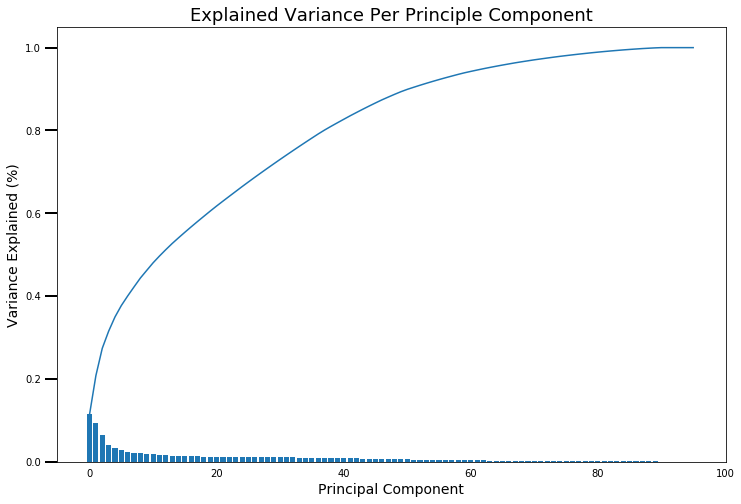

In [119]:
scree_plot(pca, figsize=(12, 8))

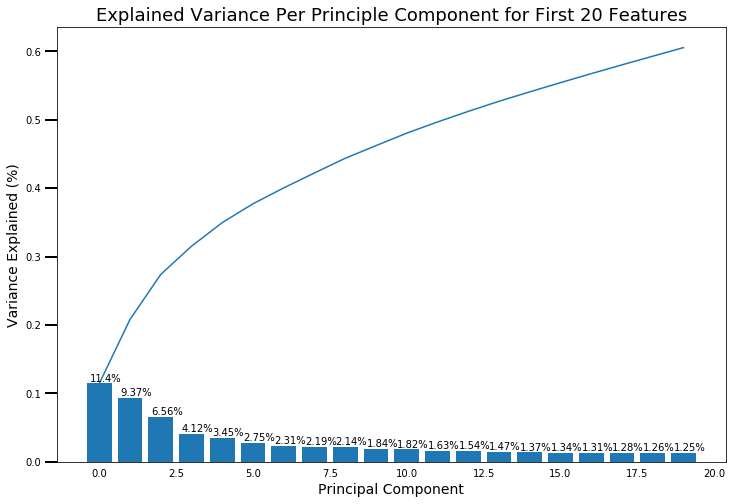

In [120]:
scree_plot(pca, annotate=True, limit=20, figsize=(12, 8))

In [121]:
pca.explained_variance_ratio_[:3].sum()

0.27395972581791594

In [122]:
for i in np.arange(5, 40, 5):
    print('For {} components, explained variance:'.format(i), 
          pca.explained_variance_ratio_[:i].sum())

For 5 components, explained variance: 0.3496819993585239
For 10 components, explained variance: 0.462164398497855
For 15 components, explained variance: 0.5407677956552905
For 20 components, explained variance: 0.60543091969792
For 25 components, explained variance: 0.6643394833792453
For 30 components, explained variance: 0.7195665567920816
For 35 components, explained variance: 0.771662979219012


In [123]:
pca.explained_variance_ratio_[:25].sum() - pca.explained_variance_ratio_[:20].sum()

0.058908563681325354

In [124]:
pca.explained_variance_ratio_[:20].sum() - pca.explained_variance_ratio_[:15].sum()

0.06466312404262942

**Observations**
- The first three components capture approximately 27% of the variance
- 50% of the variance is captured somewhere between 10 and 15 components
- The variance rises quite steadily across the components until around 50
- 75% of explained variance occurs between 30 and 35 components
- At 20 components we are explaining over 60% of the variance with just over 1% variance explained for each additional component
- There is a similar increase ratio for 15 to 20 components

In [125]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_20 = PCA(n_components=20)
X_pca_20 = pca_20.fit_transform(azdias_standard)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [126]:
# Implement collection of results based off Udacity defined function
def pca_results(full_dataset, pca):
    # Create dimensions index
    dimensions = ['Dimension {}'.format(i) for i \
                  in range(1, len(pca.components_) + 1)]
    
    # Capture pca components
    pca_comp = pca.components_
    
    # Create components df
    components_df = pd.DataFrame(np.round(pca_comp, 4), 
                              columns= full_dataset.columns)
    components_df.index = dimensions
    
    # Create PCA variance explained df
    ratios = pca.explained_variance_ratio_.reshape(len(pca_comp), 1)
    ratios_df = pd.DataFrame(np.round(ratios, 4), 
                             columns=['Explained Variance'])
    ratios_df.index = dimensions
    
    # Return combined df
    return pd.merge(ratios_df, components_df, left_index=True, right_index=True)

In [129]:
results = pca_results(azdias_consistent_code, pca_20)
results.head()

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_12,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,MAINSTREAM_AVANTGARDE,WEALTH,FAMILY_TYP
Dimension 1,0.1145,-0.1228,0.0082,0.2170,-0.1518,0.1204,-0.0777,-0.0813,-0.1522,-0.1058,...,-0.0042,0.0298,0.0651,0.0413,-0.0837,0.0594,0.0336,-0.0671,-0.2009,-0.1243
Dimension 2,0.0938,0.2443,0.0317,-0.0682,0.2381,-0.2285,0.2265,0.2352,-0.1186,-0.0065,...,0.0147,-0.0075,-0.0268,-0.0813,0.1054,-0.0355,-0.0458,-0.0505,-0.0859,-0.0062
Dimension 3,0.0657,-0.0045,-0.3262,-0.0958,0.0481,-0.0171,0.1445,0.0886,0.0573,0.0417,...,0.0108,0.0146,0.0199,-0.1791,0.1151,0.0465,-0.0118,-0.0818,-0.0170,-0.0177
Dimension 4,0.0412,0.0558,-0.1820,-0.1343,0.0237,-0.0778,0.0441,-0.0961,0.0516,0.1213,...,-0.0144,-0.0508,-0.0896,0.3255,-0.2224,-0.0121,-0.0488,0.3238,0.0371,0.0293
Dimension 5,0.0345,-0.0320,0.0726,-0.0326,0.0157,0.0231,0.1136,0.0014,0.0881,0.3217,...,0.0598,0.0107,-0.0958,-0.1415,0.0969,0.0166,0.0051,0.1754,0.0912,0.0470


In [130]:
# Implement plot of results
def plot_pca_dim(results_df, pca, dimension_name, figsize=(14, 8)):
    # Collect dimension info
    dimension = results_df.loc[dimension_name, 'ALTERSKATEGORIE_GROB':]\
    .sort_values(ascending=False)
    positive = dimension[dimension >=0]
    negative = dimension[dimension <0]
    
    # Create bar plot
    plt.figure(figsize=figsize)
    plt.subplot(211)
    positive.plot(kind='bar')
    plt.grid(axis='y')
    plt.ylabel("Feature Weights")
    plt.subplot(212)
    negative.plot(kind='bar');
    plt.grid(axis='y')
    plt.ylabel("Feature Weights")
    plt.subplots_adjust(bottom=0.8)
    plt.suptitle("{}: {}% Variance Explained".format(
        dimension_name, 
        np.round(results_df.loc[dimension_name, 'Explained Variance']*100, 2)),
                 fontsize=18)
    plt.tight_layout()

In [142]:
def weighted_features(results, dimension_name):
    print("High Positive\n", 
      results.loc[dimension_name][results.loc[dimension_name] >= 0.15].sort_values(ascending=False))
    print("\nHigh Negative\n", 
      results.loc[dimension_name][results.loc[dimension_name] <= -0.15].sort_values())

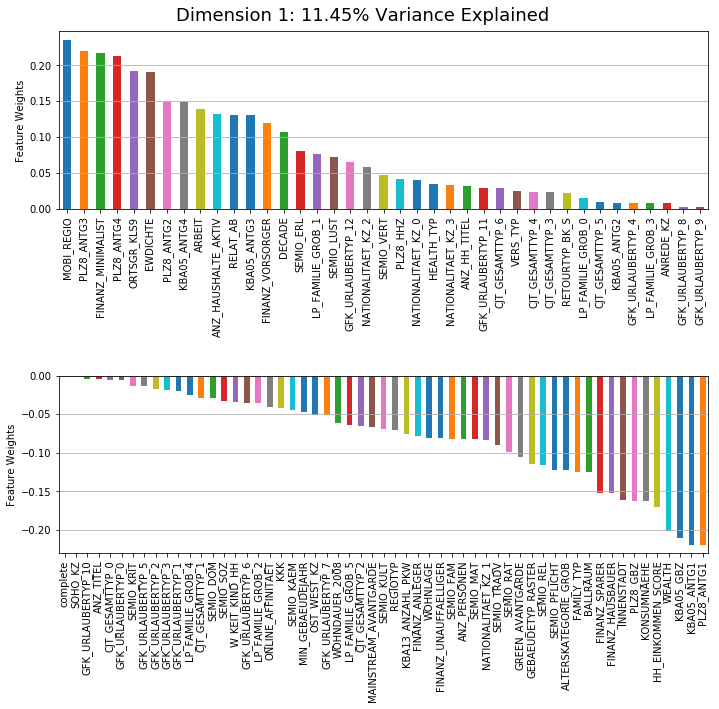

In [132]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_dim(results, pca_20, 'Dimension 1', figsize=(10, 10))

In [143]:
weighted_features(results, 'Dimension 1')

High Positive
 MOBI_REGIO           0.2352
PLZ8_ANTG3           0.2197
FINANZ_MINIMALIST    0.2170
PLZ8_ANTG4           0.2134
ORTSGR_KLS9          0.1922
EWDICHTE             0.1906
Name: Dimension 1, dtype: float64

High Negative
 PLZ8_ANTG1           -0.2194
KBA05_ANTG1          -0.2191
KBA05_GBZ            -0.2102
WEALTH               -0.2009
HH_EINKOMMEN_SCORE   -0.1707
KONSUMNAEHE          -0.1622
PLZ8_GBZ             -0.1619
INNENSTADT           -0.1608
FINANZ_HAUSBAUER     -0.1522
FINANZ_SPARER        -0.1518
Name: Dimension 1, dtype: float64


**General Note:** While exploring, I used a weight of 0.15 in either direction as the threshold for capturing strongly weighted features.

**Dimension 1**

Maps onto:
- High +ve:
    - MOBI_REGIO (Movement patterns)
    - PLZ8_ANTG3 (Number of 6-10 family houses in PLZ8 region)
    - FINANZ_MINIMALIST (Low financial interest)
    - PLZ8_ANTG4 (Number of 10+ familiy houses in PLZ8 region)
    - ORTSGR_KLS9 (Size of community)
    - EWDICHTE (Density of households per square kilometer)
- High -ve:
    - PLZ8_ANTG1 (Number of 1-2 family houses in the PLz8 region)
    - KBA05_ANTG1 (Number of 1-2 family houses in the microcell)
    - KBA05_GBZ (Number of buildings in the microcell)
    - WEALTH (High negative means more likely poor)
    - HH_EINKOMMEN_SCORE (Estimated household net income)
    - KONSUMNAEHE (Distance from building to point of sale)
    - PLZ8_GBZ (Number of buildings within the PLZ8 region)
    - INNENSTADT (Distance to city center)
    - FINANZ_HAUSBAUER (Financial typology:home ownership)
    - FINANZ_SPARER (Financial typology: money-saver)
    
These are poor people living in cities in apartment buildings who don't own their own homes and need to move a lot. 

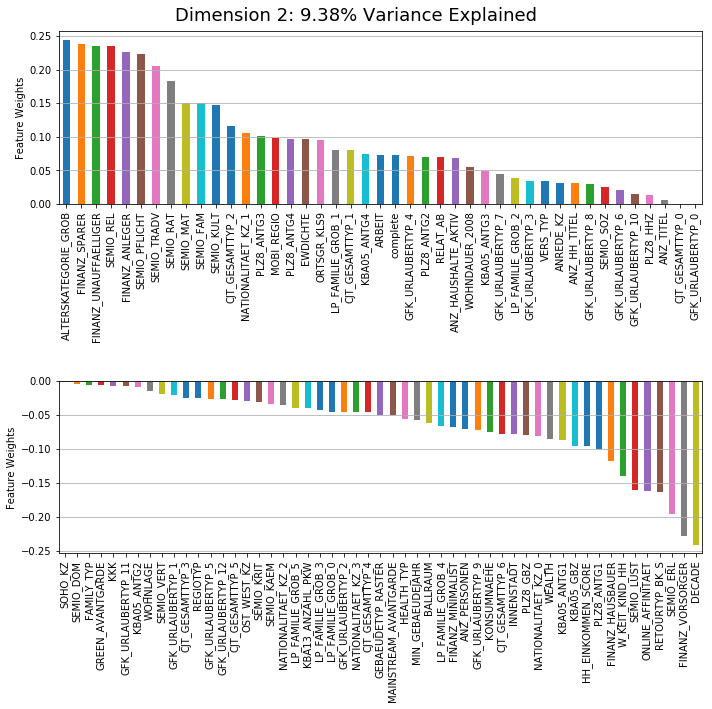

In [134]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_dim(results, pca_20, 'Dimension 2', figsize=(10, 10))

In [135]:
weighted_features(results, 'Dimension 2')

High Positive
 ALTERSKATEGORIE_GROB     0.2443
FINANZ_SPARER            0.2381
FINANZ_UNAUFFAELLIGER    0.2352
SEMIO_REL                0.2345
FINANZ_ANLEGER           0.2265
SEMIO_PFLICHT            0.2238
SEMIO_TRADV              0.2045
SEMIO_RAT                0.1822
SEMIO_MAT                0.1506
SEMIO_FAM                0.1502
Name: Dimension 2, dtype: float64

High Negative
 DECADE              -0.2417
FINANZ_VORSORGER    -0.2285
SEMIO_ERL           -0.1965
RETOURTYP_BK_S      -0.1640
ONLINE_AFFINITAET   -0.1626
SEMIO_LUST          -0.1610
Name: Dimension 2, dtype: float64


**Dimension 2**

Maps onto:
- High +ve:
    - ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
    - FINANZ_SPARER (Money-saver)
    - FINANZ_UNAUFFAELLIGER (Financial typology: inconspicuous)
    - SEMIO_REL (Relgious)
    - FINANZ_ANLEGER (Investor)
    - SEMIO_PFLICHT (Dutiful)
    - SEMIO_TRADV (Traditional-minded)
    - SEMIO_RAT (Rational)
    - SEMIO_MAT (Materialistic)
    - SEMIO_FAM (Family-minded)
- High -ve
    - DECADE (Year born - high -ve means older)
    - FINANZ_VORSORGER (Financial typology: Be prepared)
    - SEMIO_ERL (Even-oriented)
    - RETOURTYP_BK_S (Return (on purchases) type: High -ve means less likely to return purchases)
    - ONLINE_AFFINITAET (Online affinity)
    - SEMIO_LUST (Sensual-minded)
    
This is a broad category of older people who are relatively conservative with their money, and would be considered 'stereotypical' of an older generation, still interested in religion and family, while considering themselves rational.

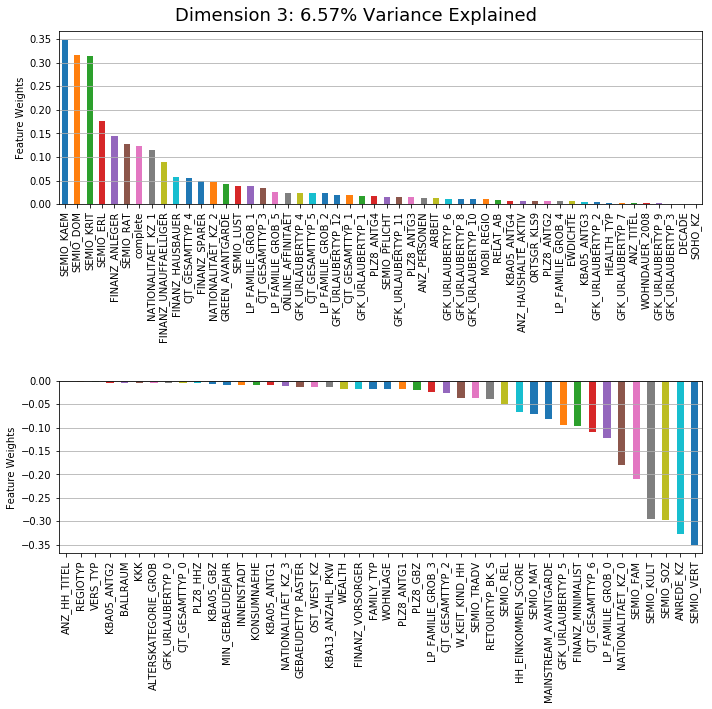

In [136]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_dim(results, pca_20, 'Dimension 3', figsize=(10, 10))

In [137]:
weighted_features(results, 'Dimension 3')

High Positive
 SEMIO_KAEM    0.3487
SEMIO_DOM     0.3153
SEMIO_KRIT    0.3144
SEMIO_ERL     0.1771
Name: Dimension 3, dtype: float64

High Negative
 SEMIO_VERT           -0.3511
ANREDE_KZ            -0.3262
SEMIO_SOZ            -0.2962
SEMIO_KULT           -0.2959
SEMIO_FAM            -0.2087
NATIONALITAET_KZ_0   -0.1791
Name: Dimension 3, dtype: float64


**Dimension 3**

Maps onto:
- High +ve:
    - SEMIO_KAEM (Combative attitude)
    - SEMIO_DOM (Dominant-minded)
    - SEMIO_KRIT (Critical-minded)
    - SEMI-ERL (Event-oriented)
- High -ve:
    - SEMIO_VERT (Dreamful)
    - ANREDE_KZ (Gender: High -ve is more likely male)
    - SEMIO_SOZ (Socially-minded)
    - SEMIO_KULT (Culturally-minded)
    - SEMIO_FAM (Family-minded)
    - NATIONALITAET_KZ_0 (Nationality based on given name analysis: Unknown)

These are men who consider themselves to be astute in their decision making, but don't live in a specific area. Interestingly, it is not likely that their nationality can't be determined or is unknown. These are the highest weights we've seen for a group.

##### Bonus Exploration
I was so thrilled by this process that I wanted to check the next couple of dimensions to see if, after the drop-off in the ratio of variance explained whether the segments were still as well defined.

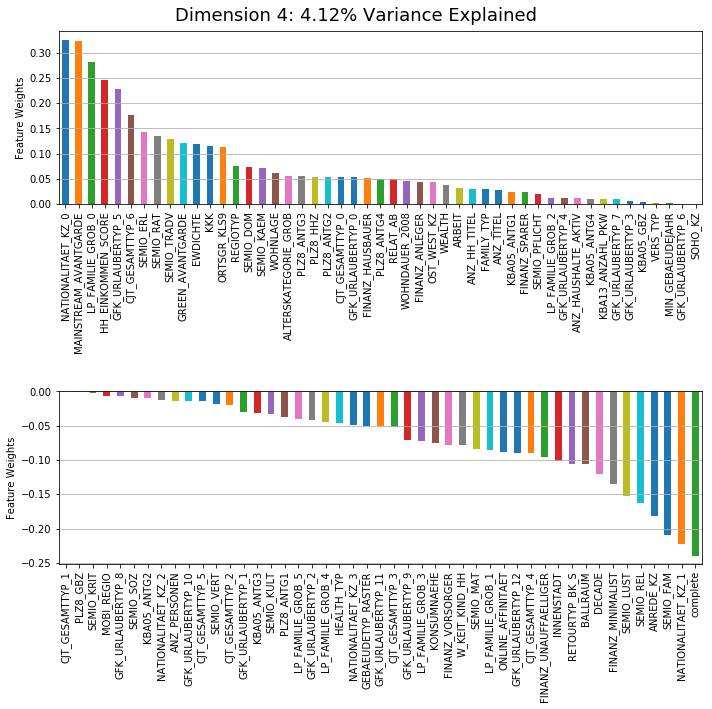

In [138]:
# Looking at the fourth dimension
plot_pca_dim(results, pca_20, 'Dimension 4', figsize=(10, 10))

In [139]:
weighted_features(results, 'Dimension 4')

High Positive
 NATIONALITAET_KZ_0       0.3255
MAINSTREAM_AVANTGARDE    0.3238
LP_FAMILIE_GROB_0        0.2806
HH_EINKOMMEN_SCORE       0.2449
GFK_URLAUBERTYP_5        0.2275
CJT_GESAMTTYP_6          0.1759
Name: Dimension 4, dtype: float64

High Negative
 complete             -0.2395
NATIONALITAET_KZ_1   -0.2224
SEMIO_FAM            -0.2097
ANREDE_KZ            -0.1820
SEMIO_REL            -0.1623
SEMIO_LUST           -0.1528
Name: Dimension 4, dtype: float64


**Dimension 4**

Maps onto:
- High +ve:
    - NATIONALITAET_KZ_0 (Nationality based on given name analysis: Unknown)
    - MAINSTREAM_AVANTGARDE (Social participation/influence: High +ve more likely avantgarde)
    - LP_FAMILIE_GROB_0 (Family type: Unknown)
    - HH_EINKOMMEN_SCORE (Estimated household net income)
    - GFK_URLAUBERTYP (Vacation habits: Nature fans)
    - CJT_GESAMTTYP_6 (Customer-Journey-Typology: Advertising-Enthusiast with restricted Cross-Channel-Behaviour)
- High -ve
    - complete (More likely to have missing data)
    - NATIONALITAET_KZ_1 (Nationality based on given name analysis: German-sounding)
    - SEMIO_FAM (Family-minded)
    - ANREDE_KZ (Gender: high -ve more likely male)
    - SEMIO_REL (Religious)
    - SEMIO_LUST (Sensual-minded)
    
This is an interesting segment of the population. It is essentially the segment that was excluded because of missing information. They are more likely for their nationality to be unknown based on name, and less likely for their name to be German-sounding. Their family status is more likely to be unknown, but they are wealthier, interested in nature, and able to be engaged through advertising. The key thing that is known about them is that they are likely to be male. They are also not interested in family, religion, and don't consider themselves sensual-minded.

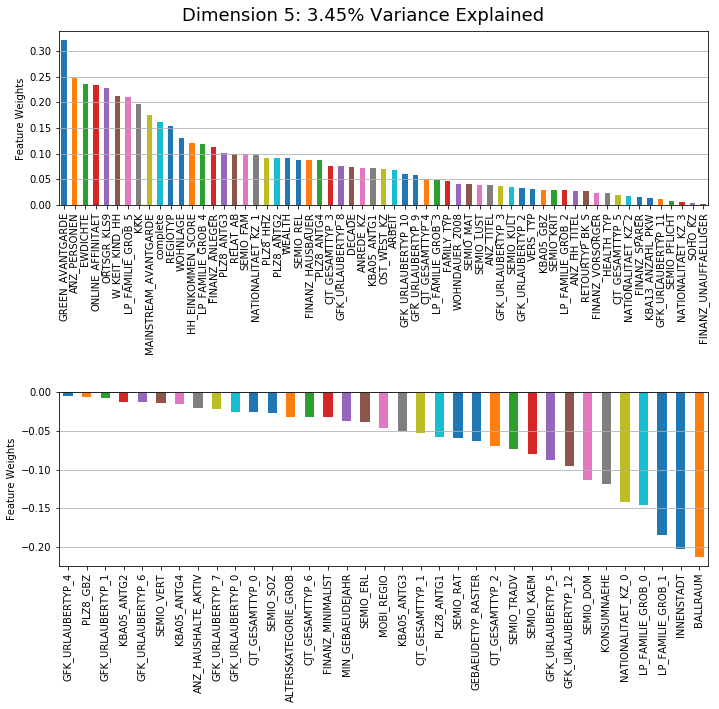

In [144]:
# Looking at the fifth dimension
plot_pca_dim(results, pca_20, 'Dimension 5', figsize=(10, 10))

In [145]:
weighted_features(results, 'Dimension 5')

High Positive
 GREEN_AVANTGARDE         0.3217
ANZ_PERSONEN             0.2471
EWDICHTE                 0.2358
ONLINE_AFFINITAET        0.2328
ORTSGR_KLS9              0.2280
W_KEIT_KIND_HH           0.2120
LP_FAMILIE_GROB_5        0.2095
KKK                      0.1963
MAINSTREAM_AVANTGARDE    0.1754
complete                 0.1617
REGIOTYP                 0.1539
Name: Dimension 5, dtype: float64

High Negative
 BALLRAUM            -0.2136
INNENSTADT          -0.2023
LP_FAMILIE_GROB_1   -0.1844
Name: Dimension 5, dtype: float64


**Dimension 5**

Maps onto:
- High +ve:
    - GREEN_AVANTGARDE (Membership in environmental sustainability as part of youth)
    - ANZ_PERSONEN (Number of adults in household)
    - EWDICHTE (Density of households per square kilometer)
    - ONLINE_AFFINITAET (Online affinity)
    - ORTSGR_KLS9 (Size of community)
    - W_KEIT_KIND_HH (Likelihood of children in household)
    - LP_FAMILIE_GROB_5 (Family type: Multiperson household, sharing and multi-generational)
    - KKK (Purchasing power in region)
    - MAINSTREAM_AVANTGARDE (Social participation/ifluence: High +ve more likely avantgarde)
    - complete (More likely to have complete data)
    - REGIOTYP (Neighborhood typology: High +ve more likely affluent)
- High -ve:
    - BALLRAUM (Distance to nearest urban center)
    - KKK (Purchasing power in region)
    - INNENSTADT (Distance to city center (downtown))
    - LP_FAMILIE_GROB_1 (Family type: Single)
    
These are essentially rich city-dwelling families. These are the people who are also most likely to have complete information.

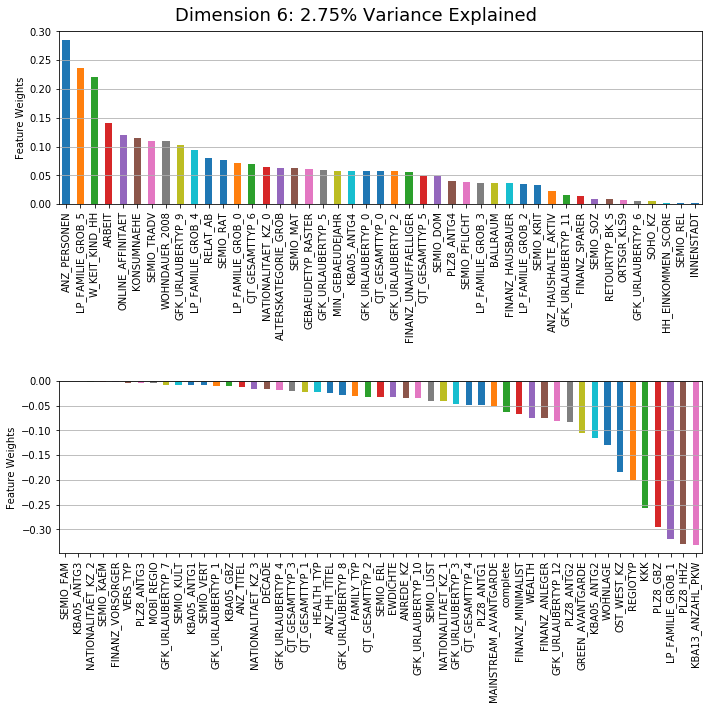

In [146]:
# Looking at the sixth dimension
plot_pca_dim(results, pca_20, 'Dimension 6', figsize=(10, 10))

In [147]:
weighted_features(results, 'Dimension 6')

High Positive
 ANZ_PERSONEN         0.2857
LP_FAMILIE_GROB_5    0.2368
W_KEIT_KIND_HH       0.2206
Name: Dimension 6, dtype: float64

High Negative
 KBA13_ANZAHL_PKW    -0.3321
PLZ8_HHZ            -0.3297
LP_FAMILIE_GROB_1   -0.3190
PLZ8_GBZ            -0.2960
KKK                 -0.2562
REGIOTYP            -0.2008
OST_WEST_KZ         -0.1848
Name: Dimension 6, dtype: float64


**Dimension 6**

Maps onto:
- High +ve:
    - ANZ_PERSONEN (Number of adults in household)
    - LP_FAMILIE_GROB_5 (Family type: Multiperson household, sharing and multi-generational)
    - W_KEIT_KIND_HH (Likelihood of children in household)
- High -ve:
    - KBA13_ANZAHL_PKW (Number of cars in the PLZ8 region)
    - PLZ8_HHZ (Number of households within the PLZ8 region)
    - LP_FAMILIE_GROB_1 (Family type: Single)
    - PLZ8_GBZ (Number of buildings within the PLZ8 region)
    - KKK (Purchasing power in region)
    - REGIOTYP (Neighborhood typology: High -ve more likely to be poor/marginal groups)
    - OST_WEST_KZ (Building location via former East / West Germany: High -ve more likely to be East)

This is poorer families living in former East Germany, not in large cities. It's interesting that the highly positive weighted features are the same as the previous, but it makes sense that it is a clear distinguishment from the rich, city dwelling families.

These segments probably do a better job of capturing the broader community groups, but they are far more generic. It makes me think that they would be much harder to target because there is a much broader scope to each group. It makes me think that the dataset where the missing values were dropped may be more helpful.

##### Investigation of dropping duplicates

One of the issues with the above data is that the means were imputed to the null values before the scaling was completed. This was necessary because without doing this, the scaling applied didn't cover the values of the rows that were dropped to calculate the scaling without them. 

It seems like it could be a good idea to investigate the details while dropping the outliers in the rows with missing values.

In [150]:
consistent_describe = azdias_consistent_code.describe()

In [156]:
azdias_consistent_code.dtypes.unique()

array([dtype('float64'), dtype('bool'), dtype('int32')], dtype=object)

In [181]:
azdias_test = azdias_consistent_code.copy()
azdias_test.complete = azdias_test.complete.astype(int)

In [183]:
test_missing = azdias_test.query('complete == 0')
outlier_rows = (test_missing > test_missing.std() * 3).sum(axis=1)
outlier_rows = outlier_rows[outlier_rows != 0]

In [186]:
azdias_no_outlier = azdias_test.drop(outlier_rows.index)
azdias_no_outlier.shape

(632255, 96)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = 

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.